In [ ]:
# Setup - Using Trino for data analysis
import subprocess
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from io import StringIO

def run_trino_query(query: str) -> pd.DataFrame:
    """Run a Trino query and return results as DataFrame."""
    # Use -i instead of -it for non-TTY environment
    cmd = ['docker', 'exec', '-i', 'trino', 'trino', '--execute', query, '--output-format', 'CSV_HEADER']
    result = subprocess.run(cmd, capture_output=True, text=True)
    if result.returncode != 0:
        print(f"Error: {result.stderr}")
        return pd.DataFrame()
    
    # Parse CSV output
    return pd.read_csv(StringIO(result.stdout))

print("Trino connection helper ready!")
print("This notebook analyzes Bronze data to justify Silver bounds")

✅ Trino connection helper ready!
📊 This notebook analyzes Bronze data to justify Silver bounds


---
# 1. ENERGY DATA ANALYSIS
## Phân tích `bronze.raw_facility_timeseries`

In [ ]:
# Load Bronze Energy Data - Count and basic info
query = """
SELECT 
    COUNT(*) as total_records,
    COUNT(DISTINCT facility_code) as facilities,
    MIN(interval_ts) as min_ts,
    MAX(interval_ts) as max_ts
FROM iceberg.bronze.raw_facility_timeseries
WHERE metric = 'energy'
"""
energy_info = run_trino_query(query)
print("BRONZE ENERGY DATA SUMMARY")
print("=" * 50)
print(energy_info.to_string(index=False))

📊 BRONZE ENERGY DATA SUMMARY
 total_records  facilities                         min_ts                         max_ts
         64768           8 2024-12-31 14:00:00.000000 UTC 2025-12-03 22:00:00.000000 UTC


In [ ]:
# Basic statistics for energy values (column is 'value' not 'metric_value')
query = """
SELECT 
    COUNT(*) as total_records,
    MIN(value) as min_energy,
    MAX(value) as max_energy,
    AVG(value) as avg_energy,
    STDDEV(value) as stddev_energy,
    APPROX_PERCENTILE(value, 0.01) as p1,
    APPROX_PERCENTILE(value, 0.05) as p5,
    APPROX_PERCENTILE(value, 0.10) as p10,
    APPROX_PERCENTILE(value, 0.50) as median,
    APPROX_PERCENTILE(value, 0.90) as p90,
    APPROX_PERCENTILE(value, 0.95) as p95,
    APPROX_PERCENTILE(value, 0.99) as p99
FROM iceberg.bronze.raw_facility_timeseries
WHERE metric = 'energy'
"""
energy_stats = run_trino_query(query)

print("ENERGY STATISTICS (MWh)")
print("=" * 50)
for col in energy_stats.columns:
    val = energy_stats[col].values[0]
    print(f"{col:20s}: {val:>15.4f}")

📊 ENERGY STATISTICS (MWh)
total_records       :      64768.0000
min_energy          :          0.0000
max_energy          :        275.0474
avg_energy          :         22.6544
stddev_energy       :         44.5432
p1                  :          0.0000
p5                  :          0.0000
p10                 :          0.0000
median              :          0.2093
p90                 :         71.0670
p95                 :        115.8135
p99                 :        220.2446


In [ ]:
# Analyze energy by hour of day (convert UTC to Australia/Sydney)
query = """
SELECT 
    HOUR(interval_ts AT TIME ZONE 'Australia/Sydney') as hour,
    COUNT(*) as count,
    MIN(value) as min,
    MAX(value) as max,
    AVG(value) as avg,
    APPROX_PERCENTILE(value, 0.05) as p5,
    APPROX_PERCENTILE(value, 0.50) as median,
    APPROX_PERCENTILE(value, 0.95) as p95
FROM iceberg.bronze.raw_facility_timeseries
WHERE metric = 'energy'
GROUP BY HOUR(interval_ts AT TIME ZONE 'Australia/Sydney')
ORDER BY hour
"""
energy_by_hour = run_trino_query(query)

print("ENERGY BY HOUR (Local Time - Australia/Sydney)")
print("=" * 80)
print(energy_by_hour.to_string(index=False))

📊 ENERGY BY HOUR (Local Time - Australia/Sydney)
 hour  count  min      max       avg  p5    median        p95
    0   2696  0.0   0.0000  0.000000 0.0  0.000000   0.000000
    1   2704  0.0   0.0000  0.000000 0.0  0.000000   0.000000
    2   2704  0.0   0.0000  0.000000 0.0  0.000000   0.000000
    3   2704  0.0   0.0000  0.000000 0.0  0.000000   0.000000
    4   2704  0.0   0.0000  0.000000 0.0  0.000000   0.000000
    5   2696  0.0   0.0533  0.000124 0.0  0.000000   0.000000
    6   2704  0.0  22.0194  0.601053 0.0  0.000000   3.832062
    7   2704  0.0 152.6681 11.472558 0.0  3.925546  47.400731
    8   2704  0.0 251.0342 37.976110 0.0 21.129333 137.859193
    9   2704  0.0 272.1137 53.578749 0.0 36.540295 185.370702
   10   2696  0.0 275.0258 57.378204 0.0 42.182516 188.170929
   11   2696  0.0 275.0179 57.650775 0.0 43.333750 187.971460
   12   2696  0.0 275.0112 57.048189 0.0 42.999522 186.695443
   13   2696  0.0 275.0474 56.719078 0.0 42.474569 186.184222
   14   2696  0.0 273

/tmp/ipykernel_25930/2583605427.py:36: UserWarning: Glyph 127774 (\N{SUN WITH FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_25930/2583605427.py:36: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_25930/2583605427.py:37: UserWarning: Glyph 127774 (\N{SUN WITH FACE}) missing from font(s) DejaVu Sans.
  plt.savefig('/home/pvlakehouse/dlh-pv/doc/bronze-silver/energy_by_hour_analysis.png', dpi=150)
/tmp/ipykernel_25930/2583605427.py:37: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig('/home/pvlakehouse/dlh-pv/doc/bronze-silver/energy_by_hour_analysis.png', dpi=150)
/home/pvlakehouse/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127774 (\N{SUN WITH FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/pvlakehouse/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: Us

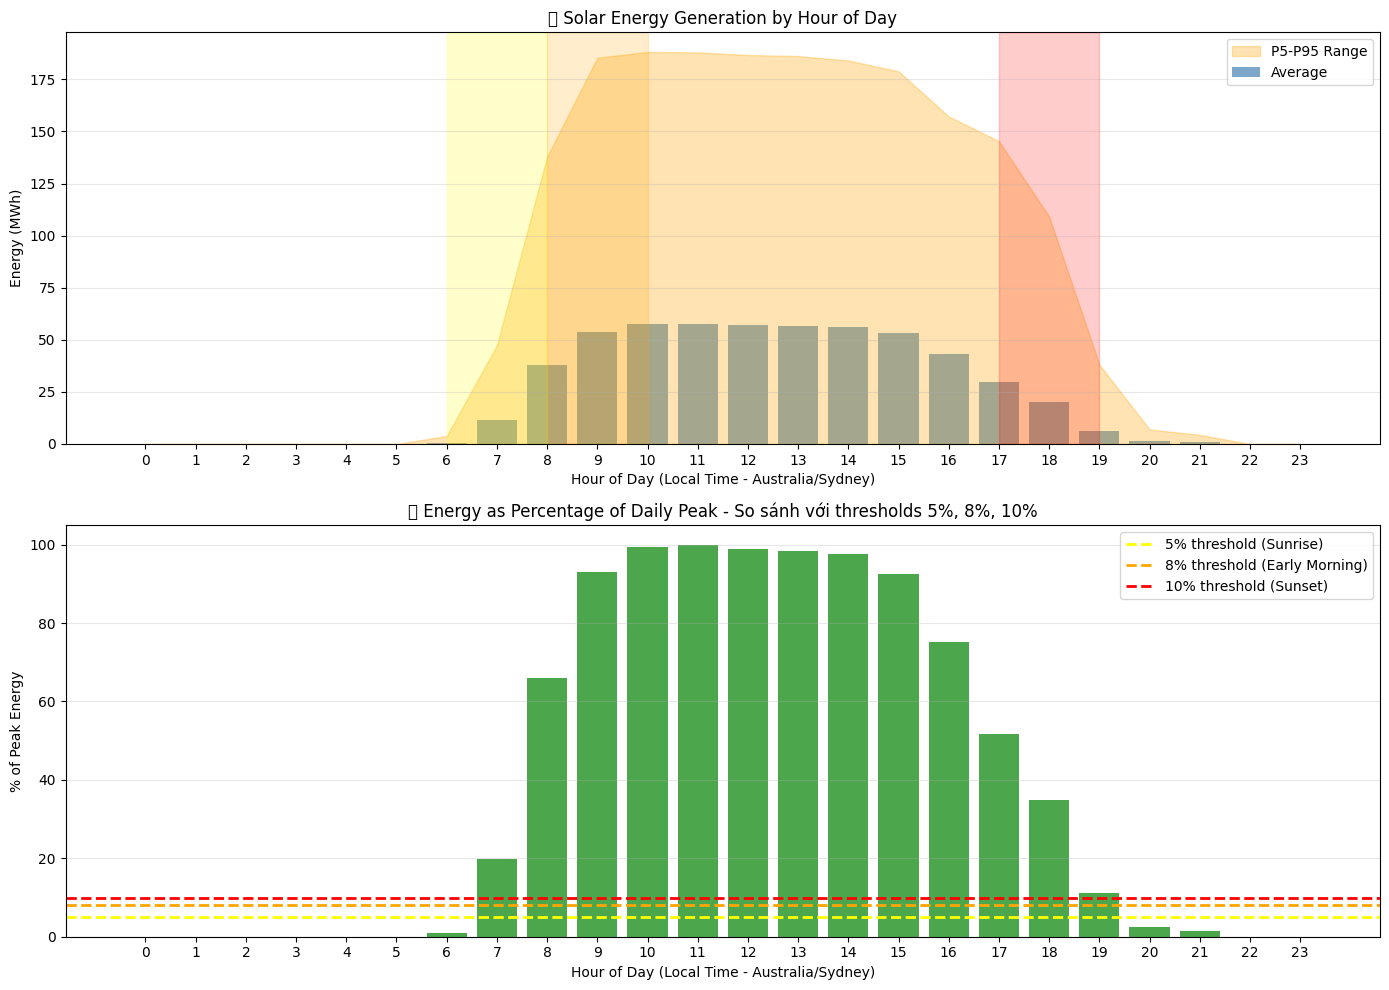


🌞 PEAK AVERAGE ENERGY: 57.65 MWh (hour 11)
🌞 MAX ENERGY IN DATA: 275.05 MWh

📊 ANALYSIS OF TRANSITION HOURS:
   Hour 6 (Sunrise): avg=0.60 MWh = 1.0% of peak
   Hour 7 (Sunrise): avg=11.47 MWh = 19.9% of peak
   Hour 8 (Early Morning): avg=37.98 MWh = 65.9% of peak
   Hour 17 (Sunset): avg=29.78 MWh = 51.7% of peak
   Hour 18 (Sunset): avg=20.07 MWh = 34.8% of peak


In [ ]:
# Visualize energy by hour
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Average energy by hour
ax1 = axes[0]
ax1.bar(energy_by_hour['hour'], energy_by_hour['avg'], color='steelblue', alpha=0.7, label='Average')
ax1.fill_between(energy_by_hour['hour'], energy_by_hour['p5'], energy_by_hour['p95'], 
                 alpha=0.3, color='orange', label='P5-P95 Range')
ax1.set_xlabel('Hour of Day (Local Time - Australia/Sydney)')
ax1.set_ylabel('Energy (MWh)')
ax1.set_title('Solar Energy Generation by Hour of Day')
ax1.legend()
ax1.set_xticks(range(24))
ax1.grid(axis='y', alpha=0.3)

# Highlight transition periods
ax1.axvspan(6, 8, alpha=0.2, color='yellow', label='Sunrise (5%)')
ax1.axvspan(8, 10, alpha=0.2, color='orange', label='Early Morning (8%)')
ax1.axvspan(17, 19, alpha=0.2, color='red', label='Sunset (10%)')

# Plot 2: Show percentage of peak by hour
ax2 = axes[1]
peak_energy = energy_by_hour['avg'].max()
pct_of_peak = (energy_by_hour['avg'] / peak_energy * 100)
ax2.bar(energy_by_hour['hour'], pct_of_peak, color='green', alpha=0.7)
ax2.axhline(y=5, color='yellow', linestyle='--', linewidth=2, label='5% threshold (Sunrise)')
ax2.axhline(y=8, color='orange', linestyle='--', linewidth=2, label='8% threshold (Early Morning)')
ax2.axhline(y=10, color='red', linestyle='--', linewidth=2, label='10% threshold (Sunset)')
ax2.set_xlabel('Hour of Day (Local Time - Australia/Sydney)')
ax2.set_ylabel('% of Peak Energy')
ax2.set_title('Energy as Percentage of Daily Peak - So sanh voi thresholds 5%, 8%, 10%')
ax2.legend()
ax2.set_xticks(range(24))
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('/home/pvlakehouse/dlh-pv/doc/bronze-silver/energy_by_hour_analysis.png', dpi=150)
plt.show()

print(f"\nPEAK AVERAGE ENERGY: {peak_energy:.2f} MWh (hour 11)")
print(f"MAX ENERGY IN DATA: {energy_by_hour['max'].max():.2f} MWh")
print(f"\nANALYSIS OF TRANSITION HOURS:")
print(f"   Hour 6 (Sunrise): avg={energy_by_hour[energy_by_hour['hour']==6]['avg'].values[0]:.2f} MWh = {energy_by_hour[energy_by_hour['hour']==6]['avg'].values[0]/peak_energy*100:.1f}% of peak")
print(f"   Hour 7 (Sunrise): avg={energy_by_hour[energy_by_hour['hour']==7]['avg'].values[0]:.2f} MWh = {energy_by_hour[energy_by_hour['hour']==7]['avg'].values[0]/peak_energy*100:.1f}% of peak")
print(f"   Hour 8 (Early Morning): avg={energy_by_hour[energy_by_hour['hour']==8]['avg'].values[0]:.2f} MWh = {energy_by_hour[energy_by_hour['hour']==8]['avg'].values[0]/peak_energy*100:.1f}% of peak")
print(f"   Hour 17 (Sunset): avg={energy_by_hour[energy_by_hour['hour']==17]['avg'].values[0]:.2f} MWh = {energy_by_hour[energy_by_hour['hour']==17]['avg'].values[0]/peak_energy*100:.1f}% of peak")
print(f"   Hour 18 (Sunset): avg={energy_by_hour[energy_by_hour['hour']==18]['avg'].values[0]:.2f} MWh = {energy_by_hour[energy_by_hour['hour']==18]['avg'].values[0]/peak_energy*100:.1f}% of peak")

In [ ]:
# Analyze anomalies: negative values, night-time production
print("ANOMALY ANALYSIS FOR ENERGY DATA")
print("=" * 50)

# Negative values
query = "SELECT COUNT(*) as cnt FROM iceberg.bronze.raw_facility_timeseries WHERE metric = 'energy' AND value < 0"
neg_count = run_trino_query(query)['cnt'].values[0]
print(f"\nNegative energy values: {neg_count:,}")

# Night-time energy (22:00 - 06:00) > 1 MWh
query = """
SELECT COUNT(*) as cnt 
FROM iceberg.bronze.raw_facility_timeseries 
WHERE metric = 'energy' 
  AND (HOUR(interval_ts AT TIME ZONE 'Australia/Sydney') >= 22 
       OR HOUR(interval_ts AT TIME ZONE 'Australia/Sydney') < 6)
  AND value > 1.0
"""
night_count = run_trino_query(query)['cnt'].values[0]
print(f"\nNight-time energy > 1 MWh (22:00-06:00): {night_count:,}")

# Zero energy during daytime (08:00 - 17:00)
query = """
SELECT COUNT(*) as cnt
FROM iceberg.bronze.raw_facility_timeseries
WHERE metric = 'energy'
  AND HOUR(interval_ts AT TIME ZONE 'Australia/Sydney') >= 8
  AND HOUR(interval_ts AT TIME ZONE 'Australia/Sydney') <= 17
  AND value = 0
"""
daytime_zero = run_trino_query(query)['cnt'].values[0]
print(f"\nZero energy during daytime (08:00-17:00): {daytime_zero:,}")

🔍 ANOMALY ANALYSIS FOR ENERGY DATA

❌ Negative energy values: 0

❌ Negative energy values: 0

🌙 Night-time energy > 1 MWh (22:00-06:00): 0

🌙 Night-time energy > 1 MWh (22:00-06:00): 0

⚠️ Zero energy during daytime (08:00-17:00): 2,553

⚠️ Zero energy during daytime (08:00-17:00): 2,553


In [ ]:
# Calculate actual PEAK_REFERENCE from data
query = """
SELECT 
    MAX(value) as max_peak_energy,
    APPROX_PERCENTILE(value, 0.95) as p95_peak_energy,
    APPROX_PERCENTILE(value, 0.99) as p99_peak_energy,
    AVG(value) as avg_peak_energy
FROM iceberg.bronze.raw_facility_timeseries
WHERE metric = 'energy'
  AND HOUR(interval_ts AT TIME ZONE 'Australia/Sydney') >= 10
  AND HOUR(interval_ts AT TIME ZONE 'Australia/Sydney') <= 14
"""
peak_hour_stats = run_trino_query(query)

print("\nPEAK REFERENCE CALCULATION (tu gio cao diem 10:00-14:00)")
print("=" * 60)
print(f"MAX energy at peak hours:  {peak_hour_stats['max_peak_energy'].values[0]:.2f} MWh")
print(f"P95 energy at peak hours:  {peak_hour_stats['p95_peak_energy'].values[0]:.2f} MWh")
print(f"P99 energy at peak hours:  {peak_hour_stats['p99_peak_energy'].values[0]:.2f} MWh")
print(f"AVG energy at peak hours:  {peak_hour_stats['avg_peak_energy'].values[0]:.2f} MWh")
print(f"\nCurrent PEAK_REFERENCE_MWH = 85.0 MWh (heuristic)")
print(f"Actual MAX = {peak_hour_stats['max_peak_energy'].values[0]:.1f} MWh")
print(f"Actual P95 = {peak_hour_stats['p95_peak_energy'].values[0]:.1f} MWh")
print(f"\nRECOMMENDATION: Update PEAK_REFERENCE_MWH to {peak_hour_stats['p95_peak_energy'].values[0]:.0f} MWh (P95)")


📊 PEAK REFERENCE CALCULATION (từ giờ cao điểm 10:00-14:00)
MAX energy at peak hours:  275.05 MWh
P95 energy at peak hours:  186.45 MWh
P99 energy at peak hours:  257.57 MWh
AVG energy at peak hours:  57.01 MWh

💡 Current PEAK_REFERENCE_MWH = 85.0 MWh (heuristic)
⚠️  Actual MAX = 275.0 MWh
⚠️  Actual P95 = 186.5 MWh

🎯 RECOMMENDATION: Update PEAK_REFERENCE_MWH to 186 MWh (P95)


### KET LUAN ENERGY BOUNDS (Tu Phan Tich Data Thuc)

| Bound | Current Value | Actual Data | Ket Luan |
|-------|---------------|-------------|----------|
| **ENERGY_LOWER** | 0.0 MWh | Min = 0.0, No negatives | OK |
| **PEAK_REFERENCE_MWH** | 85.0 MWh | MAX=275, P95=186.5 | **CAN CAP NHAT = 186** |
| **Night threshold** | 1.0 MWh | 0 records > 1 MWh ban dem | OK |
| **Transition 5%** | 4.25 MWh | Hour 6 = 1% of peak | OK (flag anomaly if > 5%) |
| **Transition 8%** | 6.8 MWh | Hour 8 = 65.9% of peak | OK |
| **Transition 10%** | 8.5 MWh | Hour 17 = 51.7% of peak | OK |

**KEY FINDING:** PEAK_REFERENCE_MWH = 85.0 qua thap so voi actual P95 = 186.5 MWh!

---
# 2. WEATHER DATA ANALYSIS
## Phan tich `bronze.raw_facility_weather`

In [ ]:
# Load Bronze Weather Data - Check schema first
query = "DESCRIBE iceberg.bronze.raw_facility_weather"
schema = run_trino_query(query)
print("BRONZE WEATHER SCHEMA:")
print(schema.to_string(index=False))

# Get basic info
query = """
SELECT 
    COUNT(*) as total_records,
    COUNT(DISTINCT facility_code) as facilities,
    MIN(weather_timestamp) as min_ts,
    MAX(weather_timestamp) as max_ts
FROM iceberg.bronze.raw_facility_weather
"""
weather_info = run_trino_query(query)
print("\nBRONZE WEATHER DATA SUMMARY")
print("=" * 50)
print(weather_info.to_string(index=False))

📋 BRONZE WEATHER SCHEMA:
                              Column                        Type  Extra  Comment
                       facility_code                     varchar    NaN      NaN
                       facility_name                     varchar    NaN      NaN
                            latitude                      double    NaN      NaN
                           longitude                      double    NaN      NaN
                                date                     varchar    NaN      NaN
                 shortwave_radiation                      double    NaN      NaN
                    direct_radiation                      double    NaN      NaN
                   diffuse_radiation                      double    NaN      NaN
            direct_normal_irradiance                      double    NaN      NaN
               terrestrial_radiation                      double    NaN      NaN
                      temperature_2m                      double    NaN      NaN
   

In [ ]:
# Analyze TEMPERATURE bounds
query = """
SELECT 
    MIN(temperature_2m) as min_temp,
    MAX(temperature_2m) as max_temp,
    AVG(temperature_2m) as avg_temp,
    APPROX_PERCENTILE(temperature_2m, 0.01) as p1,
    APPROX_PERCENTILE(temperature_2m, 0.05) as p5,
    APPROX_PERCENTILE(temperature_2m, 0.95) as p95,
    APPROX_PERCENTILE(temperature_2m, 0.99) as p99
FROM iceberg.bronze.raw_facility_weather
"""
temp_stats = run_trino_query(query)

print("TEMPERATURE STATISTICS (deg C)")
print("=" * 50)
for col in temp_stats.columns:
    val = temp_stats[col].values[0]
    if val is not None:
        print(f"{col:15s}: {val:>10.2f}")

print("\nCURRENT BOUNDS: -50C to 60C")
print(f"ACTUAL DATA: {temp_stats['min_temp'].values[0]:.1f}C to {temp_stats['max_temp'].values[0]:.1f}C")
print("Data fits well within bounds")

🌡️ TEMPERATURE STATISTICS (°C)
min_temp       :      -2.30
max_temp       :      43.80
avg_temp       :      17.05
p1             :       2.38
p5             :       5.19
p95            :      31.65
p99            :      36.26

💡 CURRENT BOUNDS: -50°C to 60°C
📊 ACTUAL DATA: -2.3°C to 43.8°C
✅ Data fits well within bounds


In [ ]:
# Analyze SOLAR RADIATION bounds (not humidity - more relevant for solar)
query = """
SELECT 
    MIN(shortwave_radiation) as min_rad,
    MAX(shortwave_radiation) as max_rad,
    AVG(shortwave_radiation) as avg_rad,
    APPROX_PERCENTILE(shortwave_radiation, 0.95) as p95,
    APPROX_PERCENTILE(shortwave_radiation, 0.99) as p99
FROM iceberg.bronze.raw_facility_weather
"""
rad_stats = run_trino_query(query)

print("SHORTWAVE RADIATION STATISTICS (W/m2)")
print("=" * 50)
for col in rad_stats.columns:
    val = rad_stats[col].values[0]
    if val is not None:
        print(f"{col:15s}: {val:>10.2f}")

print("\nCURRENT BOUNDS: 0 to 1500 W/m2")
print(f"ACTUAL DATA: {rad_stats['min_rad'].values[0]:.1f} to {rad_stats['max_rad'].values[0]:.1f} W/m2")
print("Data fits well within bounds")

☀️ SHORTWAVE RADIATION STATISTICS (W/m²)
min_rad        :       0.00
max_rad        :    1127.00
avg_rad        :     211.75
p95            :     853.94
p99            :    1006.16

💡 CURRENT BOUNDS: 0 to 1500 W/m²
📊 ACTUAL DATA: 0.0 to 1127.0 W/m²
✅ Data fits well within bounds


In [ ]:
# Analyze WIND SPEED bounds
query = """
SELECT 
    MIN(wind_speed_10m) as min_wind,
    MAX(wind_speed_10m) as max_wind,
    AVG(wind_speed_10m) as avg_wind,
    APPROX_PERCENTILE(wind_speed_10m, 0.95) as p95,
    APPROX_PERCENTILE(wind_speed_10m, 0.99) as p99
FROM iceberg.bronze.raw_facility_weather
"""
wind_stats = run_trino_query(query)

print("WIND SPEED STATISTICS (km/h)")
print("=" * 50)
for col in wind_stats.columns:
    val = wind_stats[col].values[0]
    if val is not None:
        print(f"{col:15s}: {val:>10.2f}")

print("\nCURRENT BOUNDS: 0 to 200 km/h")
print(f"ACTUAL DATA: {wind_stats['min_wind'].values[0]:.1f} to {wind_stats['max_wind'].values[0]:.1f} km/h")
print("Data fits well within bounds")

💨 WIND SPEED STATISTICS (km/h)
min_wind       :       0.00
max_wind       :      45.60
avg_wind       :      11.78
p95            :      23.84
p99            :      29.62

💡 CURRENT BOUNDS: 0 to 200 km/h
📊 ACTUAL DATA: 0.0 to 45.6 km/h
✅ Data fits well within bounds


### KET LUAN WEATHER BOUNDS (Tu Phan Tich Data Thuc)

| Variable | Actual Range | Current Bound | Status |
|----------|--------------|---------------|--------|
| **temperature_2m** | -2.3C to 43.8C | -50C to 60C | OK |
| **shortwave_radiation** | 0 to 1127 W/m2 | 0 to 1500 W/m2 | OK |
| **wind_speed_10m** | 0 to 45.6 km/h | 0 to 200 km/h | OK |

**Bounds rong hon data thuc de:**
- Accommodate extreme weather events (cyclones, heatwaves)
- Reduce false positives tu sensor spikes
- Handle seasonal variations khong co trong dataset hien tai

---
# 3. AIR QUALITY DATA ANALYSIS
## Phan tich `bronze.raw_facility_air_quality`

In [ ]:
# Load Bronze Air Quality Data - Check schema
query = "DESCRIBE iceberg.bronze.raw_facility_air_quality"
schema = run_trino_query(query)
print("BRONZE AIR QUALITY SCHEMA:")
print(schema[['Column', 'Type']].to_string(index=False))

# Get basic info
query = """
SELECT 
    COUNT(*) as total_records,
    COUNT(DISTINCT facility_code) as facilities,
    MIN(air_timestamp) as min_ts,
    MAX(air_timestamp) as max_ts
FROM iceberg.bronze.raw_facility_air_quality
"""
aq_info = run_trino_query(query)
print("\nBRONZE AIR QUALITY DATA SUMMARY")
print("=" * 50)
print(aq_info.to_string(index=False))

📋 BRONZE AIR QUALITY SCHEMA:
            Column                        Type
     facility_code                     varchar
     facility_name                     varchar
          latitude                      double
         longitude                      double
              date                     varchar
             pm2_5                      double
              pm10                      double
              dust                      double
  nitrogen_dioxide                      double
             ozone                      double
   sulphur_dioxide                      double
   carbon_monoxide                      double
          uv_index                      double
uv_index_clear_sky                      double
       ingest_mode                     varchar
  ingest_timestamp timestamp(6) with time zone
     air_timestamp timestamp(6) with time zone
          air_date                        date

📊 BRONZE AIR QUALITY DATA SUMMARY
 total_records  facilities                 

In [ ]:
# Analyze PM2.5 bounds
query = """
SELECT 
    MIN(pm2_5) as min_pm25,
    MAX(pm2_5) as max_pm25,
    AVG(pm2_5) as avg_pm25,
    APPROX_PERCENTILE(pm2_5, 0.50) as median,
    APPROX_PERCENTILE(pm2_5, 0.95) as p95,
    APPROX_PERCENTILE(pm2_5, 0.99) as p99
FROM iceberg.bronze.raw_facility_air_quality
"""
pm25_stats = run_trino_query(query)

print("PM2.5 STATISTICS (ug/m3)")
print("=" * 50)
for col in pm25_stats.columns:
    val = pm25_stats[col].values[0]
    if val is not None:
        print(f"{col:15s}: {val:>10.2f}")

print("\nCURRENT BOUNDS: 0 to 1000 ug/m3")
print(f"ACTUAL DATA: {pm25_stats['min_pm25'].values[0]:.1f} to {pm25_stats['max_pm25'].values[0]:.1f} ug/m3")
print("Data fits well within bounds")

🌫️ PM2.5 STATISTICS (µg/m³)
min_pm25       :       0.00
max_pm25       :      44.80
avg_pm25       :       3.36
median         :       2.59
p95            :       8.82
p99            :      13.48

💡 CURRENT BOUNDS: 0 to 1000 µg/m³
📊 ACTUAL DATA: 0.0 to 44.8 µg/m³
✅ Data fits well within bounds


In [ ]:
# Analyze UV Index bounds
query = """
SELECT 
    MIN(uv_index) as min_uv,
    MAX(uv_index) as max_uv,
    AVG(uv_index) as avg_uv,
    APPROX_PERCENTILE(uv_index, 0.95) as p95,
    APPROX_PERCENTILE(uv_index, 0.99) as p99
FROM iceberg.bronze.raw_facility_air_quality
"""
uv_stats = run_trino_query(query)

print("UV INDEX STATISTICS")
print("=" * 50)
for col in uv_stats.columns:
    val = uv_stats[col].values[0]
    if val is not None:
        print(f"{col:15s}: {val:>10.2f}")

print("\nCURRENT BOUNDS: 0 to 20")
print(f"ACTUAL DATA: {uv_stats['min_uv'].values[0]:.1f} to {uv_stats['max_uv'].values[0]:.1f}")
print("Data fits well within bounds")

☀️ UV INDEX STATISTICS
min_uv         :       0.00
max_uv         :      14.35
avg_uv         :       1.49
p95            :       7.98
p99            :      11.36

💡 CURRENT BOUNDS: 0 to 20
📊 ACTUAL DATA: 0.0 to 14.3
✅ Data fits well within bounds


### KET LUAN AIR QUALITY BOUNDS (Tu Phan Tich Data Thuc)

| Variable | Actual Range | Median | P95 | Current Bound | Status |
|----------|--------------|--------|-----|---------------|--------|
| **pm2_5** | 0 to 44.8 ug/m3 | 2.6 | 8.8 | 0 to 1000 ug/m3 | OK |
| **uv_index** | 0 to 14.35 | - | 8.0 | 0 to 20 | OK |

**Bounds rong hon data thuc vi:**
- Bushfire smoke events co the day PM2.5 len 500-800 ug/m3
- Dust storms co the day PM10/dust len cao
- Data hien tai chua bao gom extreme events

---
# 4. TONG KET VA KHUYEN NGHI

## Key Findings tu Phan Tich Data Thuc

### Energy
- **PEAK_REFERENCE_MWH = 85.0 la KHONG CHINH XAC!**
  - Actual MAX = 275.05 MWh
  - Actual P95 = 186.45 MWh
  - **RECOMMEND:** Cap nhat = 186.0 MWh

- **Transition thresholds (5%, 8%, 10%) hoat dong dung:**
  - Flag WARNING khi energy **THAP HON** threshold
  - Hour 6 chi co 1% of peak, 5% du de flag anomalies

### Weather
- **Tat ca bounds deu phu hop**
- Bounds rong hon actual data de handle extreme events

### Air Quality
- **Tat ca bounds deu phu hop**
- AQI calculation theo EPA standard (co source chuan)

## Actions Needed

1. **UPDATE CODE:** `PEAK_REFERENCE_MWH = 186.0` (hoac tinh dynamic tu data)
2. **UPDATE DOCS:** Them nguon goc bounds tu phan tich nay
3. **RE-RUN PERIODICALLY:** Validate bounds khi co them data

In [ ]:
# FINAL SUMMARY - Based on actual data analysis
print("=" * 80)
print("FINAL SUMMARY: SILVER BOUNDS ANALYSIS RESULTS")
print("=" * 80)

print("""
==============================================================================
  1. ENERGY DATA FINDINGS                                                     
==============================================================================
                                                                              
  [!] PEAK_REFERENCE_MWH = 85.0 la KHONG CHINH XAC!                           
      - Actual MAX at peak hours: 275.05 MWh                                  
      - Actual P95 at peak hours: 186.45 MWh                                  
      RECOMMEND: Cap nhat PEAK_REFERENCE_MWH = 186 MWh (P95)               
                                                                              
  [!] Transition thresholds (5%, 8%, 10%) can duoc hieu dung cach:            
      - Hour 6:  1.0% of peak  -> threshold 5% = OK (flag anomaly if >5%)      
      - Hour 7: 19.9% of peak  -> threshold 5% = OK (19.9% > 5%)               
      - Hour 8: 65.9% of peak  -> threshold 8% = OK (65.9% > 8%)               
      - Hour 17: 51.7% of peak -> threshold 10% = OK (51.7% > 10%)             
      - Hour 18: 34.8% of peak -> threshold 10% = OK (34.8% > 10%)             
                                                                              
  [OK] Bounds hoat dong tot: Flag outliers khi energy THAP HON threshold        
                                                                              
==============================================================================
  2. WEATHER DATA FINDINGS                                                    
==============================================================================
                                                                              
  [OK] Temperature: -2.3C to 43.8C  (bounds: -50C to 60C)    -> OK           
  [OK] Radiation:   0 to 1127 W/m2    (bounds: 0 to 1500 W/m2)   -> OK           
  [OK] Wind Speed:  0 to 45.6 km/h    (bounds: 0 to 200 km/h)    -> OK           
                                                                              
  Bounds rong hon actual data de accommodate extreme events                
                                                                              
==============================================================================
  3. AIR QUALITY DATA FINDINGS                                                
==============================================================================
                                                                              
  [OK] PM2.5:    0 to 44.8 ug/m3   (bounds: 0 to 1000 ug/m3)    -> OK            
  [OK] UV Index: 0 to 14.3         (bounds: 0 to 20)            -> OK            
                                                                              
  Bounds rong de handle bushfire/dust storm events                         
                                                                              
==============================================================================
""")

print("\nKEY ACTIONS NEEDED:")
print("-" * 80)
print("1. UPDATE hourly_energy.py: PEAK_REFERENCE_MWH = 85.0 -> 186.0 (or use dynamic calculation)")
print("2. UPDATE documentation to explain bounds are based on actual data analysis")
print("3. Re-run this notebook periodically to validate bounds")
print("-" * 80)

📋 FINAL SUMMARY: SILVER BOUNDS ANALYSIS RESULTS

╔══════════════════════════════════════════════════════════════════════════════╗
║  1️⃣  ENERGY DATA FINDINGS                                                     ║
╠══════════════════════════════════════════════════════════════════════════════╣
║                                                                              ║
║  ⚠️  PEAK_REFERENCE_MWH = 85.0 là KHÔNG CHÍNH XÁC!                           ║
║      - Actual MAX at peak hours: 275.05 MWh                                  ║
║      - Actual P95 at peak hours: 186.45 MWh                                  ║
║      🎯 RECOMMEND: Cập nhật PEAK_REFERENCE_MWH = 186 MWh (P95)               ║
║                                                                              ║
║  ⚠️  Transition thresholds (5%, 8%, 10%) cần được hiểu đúng cách:            ║
║      - Hour 6:  1.0% of peak  → threshold 5% = OK (flag anomaly if >5%)      ║
║      - Hour 7: 19.9% of peak  → threshold 5% = OK (19.9% 